<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#whether-you-use-pomdp-data" data-toc-modified-id="whether-you-use-pomdp-data-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>whether you use pomdp data</a></span></li></ul></li></ul></li><li><span><a href="#KRR-regression" data-toc-modified-id="KRR-regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>KRR regression</a></span><ul class="toc-item"><li><span><a href="#neural-data" data-toc-modified-id="neural-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>neural data</a></span><ul class="toc-item"><li><span><a href="#there-are-3-types-of-data:-test-data,-train-data,-validation-data" data-toc-modified-id="there-are-3-types-of-data:-test-data,-train-data,-validation-data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>there are 3 types of data: test data, train data, validation data</a></span></li><li><span><a href="#evaluate-model-with-test-data" data-toc-modified-id="evaluate-model-with-test-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>evaluate model with test data</a></span></li></ul></li><li><span><a href="#behavior-data" data-toc-modified-id="behavior-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>behavior data</a></span><ul class="toc-item"><li><span><a href="#there-are-3-types-of-data:-test-data,-train-data,-validation-data" data-toc-modified-id="there-are-3-types-of-data:-test-data,-train-data,-validation-data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>there are 3 types of data: test data, train data, validation data</a></span></li><li><span><a href="#evaluate-model-with-test-data" data-toc-modified-id="evaluate-model-with-test-data-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>evaluate model with test data</a></span></li></ul></li><li><span><a href="#compare-neural-and-behavior-beleifs" data-toc-modified-id="compare-neural-and-behavior-beleifs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>compare neural and behavior beleifs</a></span></li></ul></li></ul></div>

In [1]:
"""
updated 08/15/2019 by Zhengwei

Do decoding for both neural data (belief decoded from neural activity) and behavior data (beleif inferred from IRC)
compare delta b: f(b, o) - b for each case

- In k-fold, the iterations should be only from X_train instead of X
"""


'\nupdated 08/15/2019 by Zhengwei\n\nDo decoding for both neural data (belief decoded from neural activity) and behavior data (beleif inferred from IRC)\ncompare delta b: f(b, o) - b for each case\n\n- In k-fold, the iterations should be only from X_train instead of X\n'

In [2]:
"""
updated 2019-08-07 
written by Minhae Kwon


- `recoding`: Estimate the next belief from current belief and observations
    - input:
        - if you use POMDP data (for now): `recoding_pomdp_all_prev_df.csv` and `recoding_pomdp_all_now_df.csv`
        - ideally with neural data: `recoding_neural_all_prev_df.csv` and `recoding_neural_all_now_df.csv`
    - output: `recoding_belief_results_df.csv` (estimated future belief)
    - method: Autoregression - this is linear regression between two time steps. 
    - there are two versions in codes:
        -`recoding_wo_RBF.ipynb`: no RBF is used. 
        - `recoding_KRR.ipynb`: RBF is used using sklearn built-in function: [Kernel Ridge Regression (kernel ='rbf')](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html). 
        (Warning: this code runs pretty slow compared to others. So if you need to handle big data size, plan in advance!)
        - `recoding_manualRBF.ipynb`: RBF is manually coded by me. So we can customize center locations for nonlinear transform. 
        Everything is the same as `recoding_wo_RBF.ipynb` but RBF.
        - `recoding_KRR.ipynb` works the best, and pretty good!
        
        
ref: https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
https://scikit-learn.org/stable/auto_examples/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-plot-kernel-ridge-regression-py


ref: https://chrisalbon.com/machine_learning/linear_regression/linear_regression_using_scikit-learn/
     https://datatofish.com/multiple-linear-regression-python/

cross validate score: Coefficient of determination
https://en.wikipedia.org/wiki/Coefficient_of_determination
"""

from pandas import DataFrame, read_csv
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


POMDP = False
TEST_SIZE = 0.2  # ratio of test data set 
N_SPLITS = 2 # "K" in K-fold cross validation 



In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# pdf.fontype and ps.fontype must be set to 42 in order for text in exported figure to be editable in Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "CMU Serif"




In [4]:
"""
color code for color cues
"""
rgb = [[255, 0, 0],
       [255/4*3, 0, 255/4*1],
       [255/4*2, 0, 255/4*2],
       [255/4*1, 0, 255/4*3],
       [0, 0, 255]
      ] 
rgb=np.array(rgb)/255.


### whether you use pomdp data

In [5]:
if POMDP == True:
    bb_df_prev = read_csv('./data/recoding_pomdp_all_prev_df.csv')
    bb_df_now = read_csv('./data/recoding_pomdp_all_now_df.csv')
else: #neural data
    nb_df_prev = read_csv('./data/recoding_neural_all_prev_df.csv') 
    nb_df_now = read_csv('./data/recoding_neural_all_now_df.csv')
    bb_df_prev = read_csv('./data/recoding_IRC_all_prev_df.csv') 
    bb_df_now = read_csv('./data/recoding_IRC_all_now_df.csv')
    "belief data is from IRC (bb)"
    "neural data is from nn, beliefs of nn (nb)"
    

In [6]:
bb_df_prev.head()

,behavior_belief1,behavior_belief2,action,location,color 1,color 2
0,0.05,0.05,1.0,1.0,4.0,3.0
1,0.25,0.25,0.0,0.0,3.0,2.0
2,0.25,0.75,0.0,0.0,3.0,1.0
3,0.45,0.55,0.0,0.0,2.0,3.0
4,0.75,0.35,1.0,0.0,0.0,3.0


In [7]:
nb_df_prev.head()

,neural_belief1,neural_belief2,action,location,color 1,color 2
0,0.069135,0.116308,1.0,1.0,4.0,3.0
1,0.012221,0.489555,0.0,0.0,3.0,2.0
2,0.064539,0.612227,0.0,0.0,3.0,1.0
3,0.325286,0.485357,0.0,0.0,2.0,3.0
4,0.687029,0.439921,1.0,0.0,0.0,3.0


In [8]:
sensory_cue_prev = nb_df_prev[['color 1', 'color 2']].to_numpy()
sensory_cue_now = nb_df_now[['color 1', 'color 2']].to_numpy()
action_prev = nb_df_prev[['action']].to_numpy()

In [9]:
X_neural = nb_df_prev.to_numpy()#[:10000]
y_neural = nb_df_now[['neural_belief1', 'neural_belief2']].to_numpy()#[:10000]

In [10]:
X_behavior = bb_df_prev.to_numpy()#[:10000]
y_behavior = bb_df_now[['behavior_belief1', 'behavior_belief2']].to_numpy()#[:10000]

In [11]:
X = np.hstack((X_neural, X_behavior))
y = np.hstack((y_neural, y_behavior))

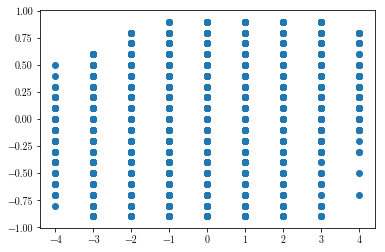

In [12]:
#plt.scatter(sensory_cue_now[:, 0] - sensory_cue_prev[:, 0], X_behavior[:, 0] - X_behavior[:,1])

In [13]:
np.corrcoef(sensory_cue_now[:, 0] - sensory_cue_prev[:, 0], X_behavior[:, 0] - X_behavior[:,1])

array([[1.        , 0.22783926],
       [0.22783926, 1.        ]])

# KRR regression

In [14]:
# separate test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = 1)

In [15]:
y_train.shape

(15999, 4)

In [16]:
X_neural_train = X_train[:, :6]
X_neural_test  = X_test[:, :6]
y_neural_train = y_train[:, :2]
y_neural_test = y_test[:, :2]

X_behavior_train = X_train[:, 6:]
X_behavior_test  = X_test[:, 6:]
y_behavior_train = y_train[:, 2:]
y_behavior_test = y_test[:, 2:]

In [17]:
# separate test data set
#X_neural_train, X_neural_test, y_neural_train, y_neural_test = train_test_split(X_neural, y_neural, test_size=TEST_SIZE, random_state = 1)

## neural data

### there are 3 types of data: test data, train data, validation data

In [18]:
#regr = LinearRegression() # linear regression is used for encoding process
regr_neural = KernelRidge(alpha=0.01, gamma=0.1, kernel='rbf') # linear regression(small gamma) with RBF kernel

In [19]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class.
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data

In [20]:
# # why argmax(1)? split cannot simply handle multidimension y. 
# # ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
# for i, (train_index, val_index) in enumerate(k_fold.split(X_train, y_train.argmax(1))):
#     x_train_kf, x_val_kf = X_neural[train_index], X_neural[val_index]
#     y_train_kf, y_val_kf = y_neural[train_index], y_neural[val_index]
#     regr_neural.fit(x_train_kf, y_train_kf) # fit the model
#     pred = regr_neural.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
#     print('score', r2_score(y_val_kf, pred, multioutput='raw_values')) # get r2 score

# score [0.56573623 0.50791511]
# score [0.62221081 0.62508066]

In [21]:
# why argmax(1)? split cannot simply handle multidimension y. 
# ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
for i, (train_index, val_index) in enumerate(k_fold.split(X_neural_train, y_neural_train.argmax(1))):
    x_train_kf, x_val_kf = X_neural_train[train_index], X_neural_train[val_index]
    y_train_kf, y_val_kf = y_neural_train[train_index], y_neural_train[val_index]
    regr_neural.fit(x_train_kf, y_train_kf) # fit the model
    pred = regr_neural.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
    print('score', r2_score(y_val_kf, pred, multioutput='raw_values')) # get r2 score


score [0.69999572 0.80987989]
score [0.69371744 0.80821933]


In [22]:
# # why argmax(1)? split cannot simply handle multidimension y. 
# # ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
# for i, (train_index, val_index) in enumerate(k_fold.split(X_neural, y_neural.argmax(1))):
#     x_train_kf, x_val_kf = X_neural[train_index], X_neural[val_index]
#     y_train_kf, y_val_kf = y_neural[train_index], y_neural[val_index]
#     regr_neural.fit(x_train_kf, y_train_kf) # fit the model
#     pred = regr_neural.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
#     print('score', r2_score(y_val_kf, pred, multioutput='raw_values')) # get r2 score

In [23]:
# model parameter
# print(regr_neural.dual_coef_.shape)
# print(regr_neural.dual_coef_)

### evaluate model with test data

In [24]:
predic_X_neural_test = regr_neural.predict(X_neural_test)

recoding_error = (y_neural_test - predic_X_neural_test)**2 # true - estimate
print('Mean squared error: \n', np.mean(recoding_error, axis=0))
print('squared error std:\n', np.std(recoding_error, axis=0))
print('score', r2_score(y_neural_test, predic_X_neural_test, multioutput='raw_values'))

Mean squared error: 
 [0.0133077  0.01374159]
squared error std:
 [0.01755265 0.01764982]
score [0.71842511 0.81776844]


In [25]:
predic_X_df_test = DataFrame(predic_X_neural_test, columns = ['neural_belief1', 'neural_belief2']) 

In [26]:
# # plot: compare raw data vs prediction
# plt.hist2d(y_neural_test[:,0], predic_X_neural_test[:,0], bins=(10, 10), cmap=plt.cm.Greys)
# plt.colorbar()
# plt.xlabel('true belief')
# plt.ylabel('estimated belief')
# plt.title('Recoding: test data BOX1')
# #plt.savefig('./figures/recoding_KRR_box1.eps', format = 'eps')


In [27]:
# # plot: compare raw data vs prediction
# #plt.scatter(a_df_test, a_dec_test, s=0.005, c='blue', marker='o')
# plt.hist2d(y_neural_test[:,1], predic_X_neural_test[:,1], bins=(10, 10), cmap=plt.cm.Greys)
# plt.colorbar()
# plt.xlabel('true belief')
# plt.ylabel('estimated belief')
# plt.title('Recoding: test data BOX2')
# #plt.savefig('./figures/recoding_KRR_box2.eps', format = 'eps')


In [28]:
# line_x = np.linspace(0,1,num=11)
# line_y = np.linspace(0,1,num=11)


# # plot: compare raw data vs prediction
# plt.scatter(y_neural_test[:,0], predic_X_neural_test[:,0], s=3, c='blue', marker='o')
# plt.plot(line_x, line_y,c='k')
# plt.xlabel('true')
# plt.ylabel('prediction')
# plt.title('Recoding: behavior belief for box1')
# plt.show()

# plt.scatter(y_neural_test[:,1], predic_X_neural_test[:,1], s=3, c='blue', marker='o')
# plt.plot(line_x, line_y,c='k')
# plt.xlabel('true')
# plt.ylabel('prediction')
# plt.title('Recoding: behavior belief for box2')
# plt.show()

## behavior data

### there are 3 types of data: test data, train data, validation data

In [29]:
# # separate test data set
# X_train, X_test, y_train, y_test = train_test_split(X_behavior, y_behavior, test_size=TEST_SIZE, random_state = 1)

In [30]:
#regr = LinearRegression() # linear regression is used for encoding process
regr_behavior = KernelRidge(alpha=0.01, gamma=0.1, kernel='rbf') # linear regression(small gamma) with RBF kernel

In [31]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class.
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data

In [32]:
# why argmax(1)? split cannot simply handle multidimension y. 
# ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
for i, (train_index, val_index) in enumerate(k_fold.split(X_behavior_train, y_behavior_train.argmax(1))):
    x_train_kf, x_val_kf = X_behavior_train[train_index], X_behavior_train[val_index]
    y_train_kf, y_val_kf = y_behavior_train[train_index], y_behavior_train[val_index]
    regr_behavior.fit(x_train_kf, y_train_kf) # fit the model
    pred = regr_behavior.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
    print('score', r2_score(y_val_kf, pred, multioutput='raw_values')) # get r2 score

score [0.68984174 0.79711955]
score [0.68327304 0.7958195 ]


In [33]:
# model parameter
# print(regr_behavior.dual_coef_.shape)
# print(regr_behavior.dual_coef_)

### evaluate model with test data

In [34]:
predic_X_behavior_test = regr_behavior.predict(X_behavior_test)

recoding_error = (y_behavior_test - predic_X_behavior_test)**2 # true - estimate
print('Mean squared error: \n', np.mean(recoding_error, axis=0))
print('squared error std:\n', np.std(recoding_error, axis=0))
print('score', r2_score(y_behavior_test, predic_X_behavior_test, multioutput='raw_values'))

Mean squared error: 
 [0.01489304 0.01501121]
squared error std:
 [0.02073934 0.02195573]
score [0.69821728 0.80640847]


In [35]:
predic_X_df_test = DataFrame(predic_X_behavior_test, columns = ['behavior_belief1', 'behavior_belief2']) 

In [36]:
# # plot: compare raw data vs prediction
# plt.hist2d(y_test[:,0], predic_X_test[:,0], bins=(10, 10), cmap=plt.cm.Greys)
# plt.colorbar()
# plt.xlabel('true belief')
# plt.ylabel('estimated belief')
# plt.title('Recoding: test data BOX1')
# #plt.savefig('./figures/recoding_KRR_box1.eps', format = 'eps')


In [37]:
# # plot: compare raw data vs prediction
# #plt.scatter(a_df_test, a_dec_test, s=0.005, c='blue', marker='o')
# plt.hist2d(y_test[:,1], predic_X_test[:,1], bins=(10, 10), cmap=plt.cm.Greys)
# plt.colorbar()
# plt.xlabel('true belief')
# plt.ylabel('estimated belief')
# plt.title('Recoding: test data BOX2')
# #plt.savefig('./figures/recoding_KRR_box2.eps', format = 'eps')


In [38]:
# line_x = np.linspace(0,1,num=11)
# line_y = np.linspace(0,1,num=11)


# # plot: compare raw data vs prediction
# plt.scatter(y_test[:,0], predic_X_test[:,0], s=3, c='blue', marker='o')
# plt.plot(line_x, line_y,c='k')
# plt.xlabel('true')
# plt.ylabel('prediction')
# plt.title('Recoding: behavior belief for box1')
# plt.show()

# plt.scatter(y_test[:,1], predic_X_test[:,1], s=3, c='blue', marker='o')
# plt.plot(line_x, line_y,c='k')
# plt.xlabel('true')
# plt.ylabel('prediction')
# plt.title('Recoding: behavior belief for box2')
# plt.show()

In [39]:
# # plot changes
# line_x = np.linspace(-.8,.8,num=11)
# line_y = np.linspace(-.8,.8,num=11)

# true_change = (y_behavior - X_behavior[:,:2])
# predic_X = regr_behavior.predict(X_behavior) # all data
# predicted_change = (predic_X - X_behavior[:,:2])

# plt.scatter(true_change[:,0], predicted_change[:,0])
# plt.plot(line_x, line_y,c='k')
# plt.xlabel('$b_{t+1}-b_t$')
# plt.ylabel('$f(b_t, o_t)-b_t$')
# plt.title('BOX1')
# #plt.savefig('./figures/recoding_DELTA_KRR_box1.eps', format = 'eps')


# plt.figure()
# plt.scatter(true_change[:,1], predicted_change[:,1])
# plt.xlabel('$b_{t+1}-b_t$')
# plt.ylabel('$f(b_t, o_t)-b_t$')
# plt.plot(line_x, line_y,c='k')
# plt.title('BOX2')
# #plt.savefig('./figures/recoding_DELTA_KRR_box2.eps', format = 'eps')

## compare neural and behavior beleifs

In [40]:
colors = ['g', 'c', 'b', 'r', 'm']
markers = ['.', '*', 'x', '+', '>']

na = 5
NumCol = 5

In [41]:
# # plot changes
# line_x = np.linspace(-.8,.8,num=11)
# line_y = np.linspace(-.8,.8,num=11)

# true_change = (y_neural - X_neural[:,:2])
# predic_X = regr_neural.predict(X_neural) # all data
# predicted_change = (predic_X - X_neural[:,:2])

# plt.scatter(true_change[:,0], predicted_change[:,0])
# plt.plot(line_x, line_y,c='k')
# plt.xlabel('$\check{b}_{t+1}-\check{b}_t$')
# plt.ylabel('$\check{f}(\check{b}_t, o_t)-\check{b}_t$')
# plt.title('box1')
# #plt.savefig('./figures/recoding_DELTA_KRR_box1.eps', format = 'eps')


# plt.figure()
# plt.scatter(true_change[:,1], predicted_change[:,1])
# plt.xlabel('$\check{b}_{t+1}-\check{b}_t$')
# plt.ylabel('$\check{f}(\check{b}_t, o_t)-\check{b}_t$')
# plt.plot(line_x, line_y,c='k')
# plt.title('bxo2')
# #plt.savefig('./figures/recoding_DELTA_KRR_box2.eps', format = 'eps')

In [42]:
# # plot changes
# line_x = np.linspace(-.8,.8,num=11)
# line_y = np.linspace(-.8,.8,num=11)

# true_change = (y_behavior - X_behavior[:,:2])
# predic_X = regr_behavior.predict(X_behavior) # all data
# predicted_change = (predic_X - X_behavior[:,:2])

# plt.scatter(true_change[:,0], predicted_change[:,0])
# plt.plot(line_x, line_y,c='k')
# plt.xlabel('$\hat{b}_{t+1}-\hat{b}_t$')
# plt.ylabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$')

# plt.title('BOX1')
# #plt.savefig('./figures/recoding_DELTA_KRR_box1.eps', format = 'eps')


# plt.figure()
# plt.scatter(true_change[:,1], predicted_change[:,1])
# plt.xlabel('$\hat{b}_{t+1}-\hat{b}_t$')
# plt.ylabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$')
# plt.plot(line_x, line_y,c='k')
# plt.title('BOX2')
# #plt.savefig('./figures/recoding_DELTA_KRR_box2.eps', format = 'eps')

In [43]:
# # plot changes
# line_x = np.linspace(-.9,.9,num=11)
# line_y = np.linspace(-.9,.9,num=11)

# true_change = (y_neural - X_neural[:,:2])
# predic_X = regr_neural.predict(X_neural) # all data
# predicted_change = (predic_X - X_neural[:,:2])


# fig_recoding_delta_neural, ax = plt.subplots(1,2,figsize=(15,7))
# plt.suptitle('comparison of neural belief change', fontsize = 24)
# fig_recoding_delta_neural.tight_layout(rect=[0, 0, 0.9, 0.9])


# h = [[] for i in range(na*NumCol)]
# idx_col_act = [[] for i in range(na*NumCol)]
# for i in range(na):
#     for j in range(NumCol):
#         idx_act = np.where(action_prev[:,0] == i)[0]
#         idx_col = np.where(sensory_cue_prev[:,0] == j)[0]
#         idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

#         h[i * NumCol + j] = ax[0].scatter(true_change[idx_col_act[i * NumCol + j],0] 
#                                           + 0.04 * (2 * np.random.random(true_change[idx_col_act[i * NumCol + j],0].shape) - 1), 
#                                           predicted_change[idx_col_act[i * NumCol + j],0], 
#                                           color = colors[j], marker = markers[i])
# ax[0].plot(line_x, line_y,c='k')
# ax[0].set(xlim = [-1, 1], ylim = [-1, 1],xticks=[-1, 0, 1], yticks = [-1, 0, 1])
# ax[0].tick_params(labelsize=14)
# ax[0].set_title('box1', fontsize = 20.0)

# g = [[] for i in range(na*NumCol)]
# idx_col_act = [[] for i in range(na*NumCol)]
# for i in range(na):
#     for j in range(NumCol):
#         idx_act = np.where(action_prev[:,0] == i)[0]
#         idx_col = np.where(sensory_cue_prev[:,0] == j)[0]
#         idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

#         g[i * NumCol + j] = ax[1].scatter(true_change[idx_col_act[i * NumCol + j],1]
#                                           + 0.04 * (2 * np.random.random(true_change[idx_col_act[i * NumCol + j], 1].shape) - 1), 
#                                           predicted_change[idx_col_act[i * NumCol + j],1], 
#                                           color = colors[j], marker = markers[i])

# ax[1].plot(line_x, line_y,c='k')
# ax[1].set(xlim = [-1, 1], ylim = [-1, 1],xticks=[-1, 0, 1], yticks = [-1, 0, 1])
# ax[1].tick_params(labelsize=14)
# ax[1].set_title('box2', fontsize = 20.0)
# #ax[1].set_xlabel('$\hat{b}_{t+1}-\hat{b}_t$', fontsize = 16)
# #ax[1].set_ylabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', fontsize = 16)


# ax[1].legend(g, ['color1, do nothing',   'color2, do nothing',   'color3, do nothing',   'color4, do nothing',   'color5, do nothing',
#                  'color1, go to center', 'color2, go to center', 'color3, go to center', 'color4, go to center', 'color5, go to center',
#                  'color1, go to box1',   'color2, go to box1',   'color3, go to box1',   'color4, action 3',     'color5, action 3',
#                  'color1, go to box2',   'color2, go to box2',   'color3, go to box2',   'color4, action 4',     'color5, action 4',
#                  'color1, press button', 'color2, press button', 'color3, press button', 'color4, press button', 'color5, press button'],
#              bbox_to_anchor=(1.1, 1.05), fontsize = 14)



# fig=ax[0].figure
# fig.text(0.45, -0.02, '$\check{b}_{t+1}-\check{b}_t$', va='center', ha='center', fontsize = 16)
# fig.text(-0.02, 0.5, '$\check{f}(\check{b}_t, o_t)-\check{b}_t$', va='center', ha='center', rotation='vertical', fontsize = 16)
# #fig_recoding_delta_neural.savefig('figures/recoding_delta_neural.pdf', format = 'pdf', bbox_inches="tight")




In [44]:
# # plot changes
# line_x = np.linspace(-.9,.9,num=11)
# line_y = np.linspace(-.9,.9,num=11)

# #behavior_change = (regr_behavior.predict(X_behavior) - X_behavior[:,:2])
# #neural_change = (regr_neural.predict(X_neural) - X_neural[:,:2])

# true_change = (y_behavior - X_behavior[:,:2])
# predic_X = regr_behavior.predict(X_behavior) # all data
# predicted_change = (predic_X - X_behavior[:,:2])

# fig_recoding_delta_behavior_jitter, ax = plt.subplots(1,2,figsize=(15,7))
# plt.suptitle('comparison of behavior belief change', fontsize = 24)
# fig_recoding_delta_behavior_jitter.tight_layout(rect=[0, 0, 0.9, 0.9])

# h = [[] for i in range(na*NumCol)]
# idx_col_act = [[] for i in range(na*NumCol)]
# for i in range(na):
#     for j in range(NumCol):
#         idx_act = np.where(action_prev[:,0] == i)[0]
#         idx_col = np.where(sensory_cue_prev[:,0] == j)[0]
#         idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

#         h[i * NumCol + j] = ax[0].scatter(true_change[idx_col_act[i * NumCol + j],0] 
#                                           + 0.04 * (2 * np.random.random(true_change[idx_col_act[i * NumCol + j],0].shape) - 1), 
#                                           predicted_change[idx_col_act[i * NumCol + j],0], 
#                                           color = colors[j], marker = markers[i])
# ax[0].plot(line_x, line_y,c='k')
# ax[0].set(xlim = [-1, 1], ylim = [-1, 1],xticks=[-1, 0, 1], yticks = [-1, 0, 1])
# ax[0].tick_params(labelsize=14)
# ax[0].set_title('box1', fontsize = 20.0)

# g = [[] for i in range(na*NumCol)]
# idx_col_act = [[] for i in range(na*NumCol)]
# for i in range(na):
#     for j in range(NumCol):
#         idx_act = np.where(action_prev[:,0] == i)[0]
#         idx_col = np.where(sensory_cue_prev[:,0] == j)[0]
#         idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

#         g[i * NumCol + j] = ax[1].scatter(true_change[idx_col_act[i * NumCol + j],1]
#                                           + 0.04 * (2 * np.random.random(true_change[idx_col_act[i * NumCol + j], 1].shape) - 1), 
#                                           predicted_change[idx_col_act[i * NumCol + j],1], 
#                                           color = colors[j], marker = markers[i])

# ax[1].plot(line_x, line_y,c='k')
# ax[1].set(xlim = [-1, 1], ylim = [-1, 1],xticks=[-1, 0, 1], yticks = [-1, 0, 1])
# ax[1].tick_params(labelsize=14)
# ax[1].set_title('box2', fontsize = 20.0)
# #ax[1].set_xlabel('$\hat{b}_{t+1}-\hat{b}_t$', fontsize = 16)
# #ax[1].set_ylabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', fontsize = 16)


# ax[1].legend(g, ['color1, do nothing',   'color2, do nothing',   'color3, do nothing',   'color4, do nothing',   'color5, do nothing',
#                  'color1, go to center', 'color2, go to center', 'color3, go to center', 'color4, go to center', 'color5, go to center',
#                  'color1, go to box1',   'color2, go to box1',   'color3, go to box1',   'color4, action 3',     'color5, action 3',
#                  'color1, go to box2',   'color2, go to box2',   'color3, go to box2',   'color4, action 4',     'color5, action 4',
#                  'color1, press button', 'color2, press button', 'color3, press button', 'color4, press button', 'color5, press button'],
#              bbox_to_anchor=(1.1, 1.05), fontsize = 14)

# fig=ax[0].figure
# fig.text(0.45, -0.02, '$\hat{b}_{t+1}-\hat{b}_t$', va='center', ha='center', fontsize = 16)
# fig.text(-0.02, 0.5, '$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', va='center', ha='center', rotation='vertical', fontsize = 16)
# #fig_recoding_delta_behavior_jitter.savefig('figures/recoding_delta_behavior_jitter.pdf', format = 'pdf', bbox_inches="tight")



In [45]:
# # plot changes
# line_x = np.linspace(-.9,.9,num=11)
# line_y = np.linspace(-.9,.9,num=11)

# #behavior_change = (regr_behavior.predict(X_behavior) - X_behavior[:,:2])
# #neural_change = (regr_neural.predict(X_neural) - X_neural[:,:2])

# true_change = (y_behavior - X_behavior[:,:2])
# predic_X = regr_behavior.predict(X_behavior) # all data
# predicted_change = (predic_X - X_behavior[:,:2])

# fig_recoding_delta_behavior, ax = plt.subplots(1,2,figsize=(15,7))
# plt.suptitle('comparison of behavior belief change', fontsize = 24)
# fig_recoding_delta_behavior.tight_layout(rect=[0, 0, 0.9, 0.9])

# h = [[] for i in range(na*NumCol)]
# idx_col_act = [[] for i in range(na*NumCol)]
# for i in range(na):
#     for j in range(NumCol):
#         idx_act = np.where(action_prev[:,0] == i)[0]
#         idx_col = np.where(sensory_cue_prev[:,0] == j)[0]
#         idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

#         h[i * NumCol + j] = ax[0].scatter(true_change[idx_col_act[i * NumCol + j],0], 
#                                           predicted_change[idx_col_act[i * NumCol + j],0], 
#                                           color = colors[j], marker = markers[i])
# ax[0].plot(line_x, line_y,c='k')
# ax[0].set(xlim = [-1, 1], ylim = [-1, 1],xticks=[-1, 0, 1], yticks = [-1, 0, 1])
# ax[0].tick_params(labelsize=14)
# ax[0].set_title('box1', fontsize = 20.0)

# g = [[] for i in range(na*NumCol)]
# idx_col_act = [[] for i in range(na*NumCol)]
# for i in range(na):
#     for j in range(NumCol):
#         idx_act = np.where(action_prev[:,0] == i)[0]
#         idx_col = np.where(sensory_cue_prev[:,0] == j)[0]
#         idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

#         g[i * NumCol + j] = ax[1].scatter(true_change[idx_col_act[i * NumCol + j],1], 
#                                           predicted_change[idx_col_act[i * NumCol + j],1], 
#                                           color = colors[j], marker = markers[i])

# ax[1].plot(line_x, line_y,c='k')
# ax[1].set(xlim = [-1, 1], ylim = [-1, 1],xticks=[-1, 0, 1], yticks = [-1, 0, 1])
# ax[1].tick_params(labelsize=14)
# ax[1].set_title('box2', fontsize = 20.0)
# #ax[1].set_xlabel('$\hat{b}_{t+1}-\hat{b}_t$', fontsize = 16)
# #ax[1].set_ylabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', fontsize = 16)


# ax[1].legend(g, ['color1, do nothing',   'color2, do nothing',   'color3, do nothing',   'color4, do nothing',   'color5, do nothing',
#                  'color1, go to center', 'color2, go to center', 'color3, go to center', 'color4, go to center', 'color5, go to center',
#                  'color1, go to box1',   'color2, go to box1',   'color3, go to box1',   'color4, action 3',     'color5, action 3',
#                  'color1, go to box2',   'color2, go to box2',   'color3, go to box2',   'color4, action 4',     'color5, action 4',
#                  'color1, press button', 'color2, press button', 'color3, press button', 'color4, press button', 'color5, press button'],
#              bbox_to_anchor=(1.1, 1.05), fontsize = 14)

# fig=ax[0].figure
# fig.text(0.45, -0.02, '$\hat{b}_{t+1}-\hat{b}_t$', va='center', ha='center', fontsize = 16)
# fig.text(-0.02, 0.5, '$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', va='center', ha='center', rotation='vertical', fontsize = 16)
# fig_recoding_delta_behavior.savefig('figures/recoding_delta_behavior.pdf', format = 'pdf', bbox_inches="tight")




In [46]:
neural_color = 'blueviolet'

action 0 color 0 0.8988364957779785
action 0 color 1 0.9334575631338903
action 0 color 2 0.9392074340303704
action 0 color 3 0.9031715976566943
action 0 color 4 0.9097374473780322
action 1 color 0 0.8896968864996218
action 1 color 1 0.9214770158773276
action 1 color 2 0.9229594586845695
action 1 color 3 0.9048426573234934
action 1 color 4 0.8564740178142488
action 2 color 0 0.9415324107993802
action 2 color 1 0.9416568063885074
action 2 color 2 0.9166869892963906
action 2 color 3 0.8837027913354829
action 2 color 4 0.7498644299630428
action 3 color 0 0.8438349071911856
action 3 color 1 0.929288771063066
action 3 color 2 0.9484048373394639
action 3 color 3 0.9455254861451909
action 3 color 4 0.9312221154029262
action 4 color 0 0.9951866731222709
action 4 color 1 0.9938354603587012
action 4 color 2 0.992508608984612
action 4 color 3 0.9913409663483425
action 4 color 4 0.988186901503381


Text(-0.08,0.45,'Belief change predicted from neurons')

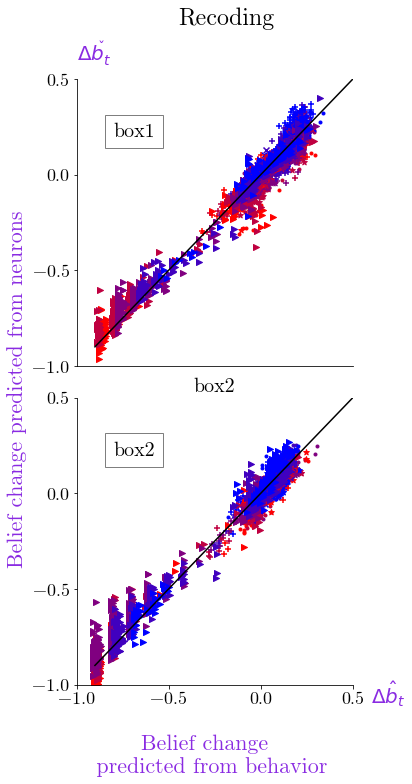

In [47]:
# plot changes
line_x = np.linspace(-.9,.9,num=11)
line_y = np.linspace(-.9,.9,num=11)

behavior_change = (regr_behavior.predict(X_behavior) - X_behavior[:,:2])
neural_change = (regr_neural.predict(X_neural) - X_neural[:,:2])

fig_recoding_delta, ax = plt.subplots(2,1,figsize=(5,10))
plt.suptitle('Recoding', fontsize = 24, fontweight='bold')
fig_recoding_delta.tight_layout(rect=[0, 0, 0.9, 0.9])

h = [[] for i in range(na*NumCol)]
idx_col_act = [[] for i in range(na*NumCol)]
for i in range(na):
    for j in range(NumCol):
        idx_act = np.where(action_prev[:,0] == i)[0]
        idx_col = np.where(sensory_cue_prev[:,0] == j)[0]
        idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

        h[i * NumCol + j] = ax[0].scatter(behavior_change[idx_col_act[i * NumCol + j],0], neural_change[idx_col_act[i * NumCol + j],0], 
                     color = rgb[j], marker = markers[i])
ax[0].plot(line_x, line_y,c='k')
ax[0].set(xlim = [-1, .5], ylim = [-1, .5],
          xticks=[], yticks = [-1, -0.5, 0, 0.5])
ax[0].tick_params(labelsize=14)
#ax[0].set_title('box1', fontsize = 20.0)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].text(-1, 0.6, '$\Delta b^{\check}_t$',  fontsize = 20.0, color = neural_color)
ax[0].text(-.8, .2, 'box1',  fontsize = 20.0,
        bbox={'facecolor': 'none', 'alpha': 0.5, 'pad': 8})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(18)


#ax[0].set_xlabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', fontsize = 16)
#ax[0].set_ylabel('$\check{f}(\check{b}_t, o_t)-\check{b}_t$', fontsize = 16)

#plt.savefig('./figures/recoding_DELTA_KRR_box1.eps', format = 'eps')
corre_mat = np.zeros((na, NumCol))
g = [[] for i in range(na*NumCol)]
idx_col_act = [[] for i in range(na*NumCol)]
for i in range(na):
    for j in range(NumCol):
        idx_act = np.where(action_prev[:,0] == i)[0]
        idx_col = np.where(sensory_cue_prev[:,1] == j)[0]
        idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

        g[i * NumCol + j] = ax[1].scatter(behavior_change[idx_col_act[i * NumCol + j],1], neural_change[idx_col_act[i * NumCol + j],1], 
                     color = rgb[j], marker = markers[i])
        x1 = behavior_change[idx_col_act[i * NumCol + j],1]
        x2 = neural_change[idx_col_act[i * NumCol + j], 1]
        print('action', i, 'color', j, np.corrcoef(x1, x2)[0, 1]) 
        corre_mat[i, j] = np.corrcoef(x1, x2)[0, 1]

ax[1].plot(line_x, line_y,c='k')
ax[1].set(xlim = [-1, .5], ylim = [-1, .5],
          xticks=[-1, -0.5, 0, 0.5], yticks = [-1, -0.5, 0, 0.5])
ax[1].tick_params(labelsize=14)
ax[1].set_title('box2', fontsize = 20.0)
#ax[1].set_xlabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', fontsize = 16)
#ax[1].set_ylabel('$\check{f}(\check{b}_t, o_t)-\check{b}_t$', fontsize = 16)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].text(0.6, -1.1, '$\Delta\hat{b}_t$',  fontsize = 20.0, color = neural_color)
ax[1].text(-.8, .2, 'box2',  fontsize = 20.0,
        bbox={'facecolor': 'none', 'alpha': 0.5, 'pad': 8})
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(18)



# ax[1].legend(g, ['color1, do nothing',   'color2, do nothing',   'color3, do nothing',   'color4, do nothing',   'color5, do nothing',
#                  'color1, go to center', 'color2, go to center', 'color3, go to center', 'color4, go to center', 'color5, go to center',
#                  'color1, go to box1',   'color2, go to box1',   'color3, go to box1',   'color4, action 3',     'color5, action 3',
#                  'color1, go to box2',   'color2, go to box2',   'color3, go to box2',   'color4, action 4',     'color5, action 4',
#                  'color1, press button', 'color2, press button', 'color3, press button', 'color4, press button', 'color5, press button'],
#              bbox_to_anchor=(1.1, 1.05), fontsize = 14)



fig=ax[0].figure
# fig.text(0.45, -0.02, '$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', va='center', ha='center', fontsize = 16)
# fig.text(-0.02, 0.5, '$\check{f}(\check{b}_t, o_t)-\check{b}_t$', va='center', ha='center', rotation='vertical', fontsize = 16)
fig.text(0.45, -0.06, 'Belief change \n predicted from behavior', 
         va='center', ha='center', fontsize = 22, color=neural_color)
fig.text(-0.08, 0.45, 'Belief change predicted from neurons', 
         va='center', ha='center', rotation='vertical', fontsize = 22, color=neural_color)

#fig_recoding_delta.savefig('recoding_delta.pdf', format = 'pdf', bbox_inches="tight")



'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


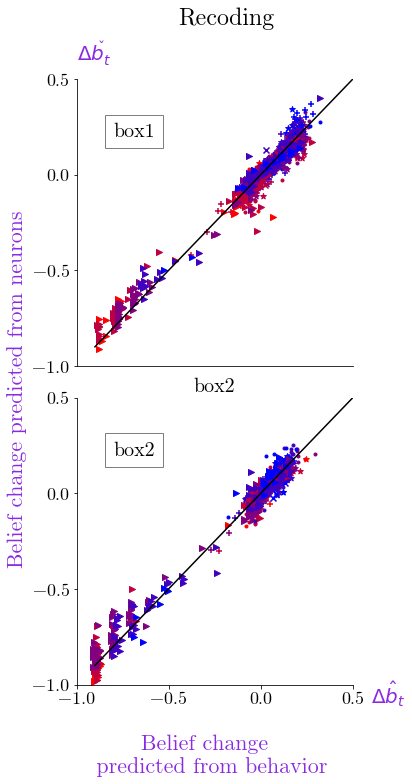

In [48]:
"""
test data
"""
# plot changes
line_x = np.linspace(-.9,.9,num=11)
line_y = np.linspace(-.9,.9,num=11)

behavior_change = (regr_behavior.predict(X_behavior_test) - X_behavior_test[:,:2])
neural_change = (regr_neural.predict(X_neural_test) - X_neural_test[:,:2])

fig_recoding_delta, ax = plt.subplots(2,1,figsize=(5,10))
plt.suptitle('Recoding', fontsize = 24, fontweight='bold')
fig_recoding_delta.tight_layout(rect=[0, 0, 0.9, 0.9])

h = [[] for i in range(na*NumCol)]
idx_col_act = [[] for i in range(na*NumCol)]
for i in range(na):
    for j in range(NumCol):
        idx_act = np.where(X_behavior_test[:, 2] == i)[0]  #action 
        idx_col = np.where(X_behavior_test[:,4] == j)[0]   #col1
        idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))

        h[i * NumCol + j] = ax[0].scatter(behavior_change[idx_col_act[i * NumCol + j],0], 
                                          neural_change[idx_col_act[i * NumCol + j],0], 
                     color = rgb[j], marker = markers[i])
ax[0].plot(line_x, line_y,c='k')
ax[0].set(xlim = [-1, .5], ylim = [-1, .5],
          xticks=[], yticks = [-1, -0.5, 0, 0.5])
ax[0].tick_params(labelsize=14)
#ax[0].set_title('box1', fontsize = 20.0)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].text(-1, 0.6, '$\Delta b^{\check}_t$',  fontsize = 20.0, color = neural_color)
ax[0].text(-.8, .2, 'box1',  fontsize = 20.0,
        bbox={'facecolor': 'none', 'alpha': 0.5, 'pad': 8})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(18)


#ax[0].set_xlabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', fontsize = 16)
#ax[0].set_ylabel('$\check{f}(\check{b}_t, o_t)-\check{b}_t$', fontsize = 16)

#plt.savefig('./figures/recoding_DELTA_KRR_box1.eps', format = 'eps')
corre_mat = np.zeros((na, NumCol))
g = [[] for i in range(na*NumCol)]
idx_col_act = [[] for i in range(na*NumCol)]
for i in range(na):
    for j in range(NumCol):
        idx_act = np.where(X_behavior_test[:,2] == i)[0]  #action 
        idx_col = np.where(X_behavior_test[:,5] == j)[0]  #col2
        idx_col_act[i * NumCol + j] = list(np.intersect1d(idx_act, idx_col))
        #print(idx_act, idx_col)

        g[i * NumCol + j] = ax[1].scatter(behavior_change[idx_col_act[i * NumCol + j],1], 
                                          neural_change[idx_col_act[i * NumCol + j],1], 
                     color = rgb[j], marker = markers[i])
#         x1 = behavior_change[idx_col_act[i * NumCol + j],1]
#         x2 = neural_change[idx_col_act[i * NumCol + j], 1]
#         print('action', i, 'color', j, np.corrcoef(x1, x2)[0, 1]) 
#         corre_mat[i, j] = np.corrcoef(x1, x2)[0, 1]

ax[1].plot(line_x, line_y,c='k')
ax[1].set(xlim = [-1, .5], ylim = [-1, .5],
          xticks=[-1, -0.5, 0, 0.5], yticks = [-1, -0.5, 0, 0.5])
ax[1].tick_params(labelsize=14)
ax[1].set_title('box2', fontsize = 20.0)
#ax[1].set_xlabel('$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', fontsize = 16)
#ax[1].set_ylabel('$\check{f}(\check{b}_t, o_t)-\check{b}_t$', fontsize = 16)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].text(0.6, -1.1, '$\Delta\hat{b}_t$',  fontsize = 20.0, color = neural_color)
ax[1].text(-.8, .2, 'box2',  fontsize = 20.0,
        bbox={'facecolor': 'none', 'alpha': 0.5, 'pad': 8})
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(18)



# ax[1].legend(g, ['color1, do nothing',   'color2, do nothing',   'color3, do nothing',   'color4, do nothing',   'color5, do nothing',
#                  'color1, go to center', 'color2, go to center', 'color3, go to center', 'color4, go to center', 'color5, go to center',
#                  'color1, go to box1',   'color2, go to box1',   'color3, go to box1',   'color4, action 3',     'color5, action 3',
#                  'color1, go to box2',   'color2, go to box2',   'color3, go to box2',   'color4, action 4',     'color5, action 4',
#                  'color1, press button', 'color2, press button', 'color3, press button', 'color4, press button', 'color5, press button'],
#              bbox_to_anchor=(1.1, 1.05), fontsize = 14)



fig=ax[0].figure
# fig.text(0.45, -0.02, '$\hat{f}(\hat{b}_t, o_t)-\hat{b}_t$', va='center', ha='center', fontsize = 16)
# fig.text(-0.02, 0.5, '$\check{f}(\check{b}_t, o_t)-\check{b}_t$', va='center', ha='center', rotation='vertical', fontsize = 16)
fig.text(0.45, -0.06, 'Belief change \n predicted from behavior', 
         va='center', ha='center', fontsize = 22, color=neural_color)
fig.text(-0.08, 0.45, 'Belief change predicted from neurons', 
         va='center', ha='center', rotation='vertical', fontsize = 22, color=neural_color)

fig_recoding_delta.savefig('recoding_delta.pdf', format = 'pdf', bbox_inches="tight")


